Preprocessing external data...
OUTLIER DETECTED
OUTLIER DETECTED
OUTLIER DETECTED
OUTLIER DETECTED
196
create dataframe from dictionary
Normalizing data
Preprocessing done
Preparing classification task
---------------------------
Data Exploration
Correlation plot
Total number of filled pauses for 452 TED talks: 229
Total number of filled pauses for 452 Audio books: 30
Prcentage filled pauses in TED: 0.884
Training on pause features
--------------------------------------
Preparing binary classification task
Accuracy, logistic regression: 0.607
F1 score, logistic regression: 0.599
Accuracy for RandomForestClassifier: 0.807
F1 score, RandomForestClassifier: 0.764
Accuracy for Naive Bayes Classifier: 0.713
F1 score, Naive Bayes: 0.557
Accuracy for Gradient Boosting: 0.807
F1 score, Gradient Boosting: 0.764
------------------------------
Run SVD on features to deal with sparsity
Train on new features
Accuracy, logistic regression: 0.607
F1 score, logistic regression: 0.599
Accuracy for Rand

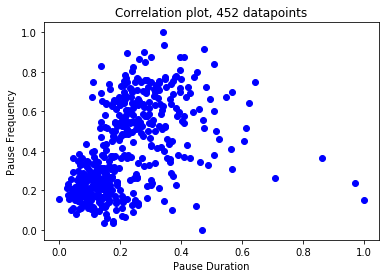

In [14]:
import os, json
import pandas as pd, numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
#from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier

# this finds our json files
path_to_json = '../data_folder/json_api'
#path_to_json = 'data_folder/api_jsons'
null = None
false = False
true = True
NoneType = None

new_dict = {}
new_dict["pause_duration"] = []
new_dict["no_of_pauses"] = []
new_dict["uh_duration"] = []
new_dict["no_of_uh"] = []
new_dict["um_duration"] = []
new_dict["no_of_um"] = []
new_dict["binary_classifier"] = []

pause_duration = []
pause_per_sec = []
setter = set()
inter = set()

filled_ted = 0
filled_audio = 0
print("Preprocessing external data...")
# we need both the json and an index number so use enumerate()
for subdir, dirs, files in os.walk(path_to_json):
      for file in files:
        if file.endswith(".json"):
            path = os.path.join(subdir, file)
            
            with open(path) as f:
                json_text = json.loads(f.read())
                #json_text = json.loads(f)
                
            json_text = eval(json_text)
            score = json_text["Score"]
            json_text = json_text["AnalysisResult"]
            
            #id_ = json_text["id"]
            feature_dict = {}

            if score < 5:
                print("OUTLIER DETECTED")
                continue
                
            elapsed_time = json_text["performance"]["elapsed_time"]
            counter_pauses = 0
            counter_uh = 0
            counter_um = 0
            timer_pauses = 0
            timer_uh = 0
            timer_um = 0
            
            for tok in json_text["tokens"]:
                Text = tok["text"].lower()
                if (Text == "sil"):
                    pause_time = tok["end_time"] - tok["start_time"]
                    timer_pauses += pause_time
                    counter_pauses += 1
                elif (Text == "uh"):
                    uh_time = tok["end_time"] - tok["start_time"]
                    timer_uh += uh_time
                    counter_uh += 1
                    if "TED" in file:
                        filled_ted += 1
                    else: filled_audio += 1
                elif (Text == "um"):
                    um_time = tok["end_time"] - tok["start_time"]
                    timer_um += um_time
                    counter_um += 1
                    if "TED" in file:
                        filled_ted += 1
                    else: filled_audio += 1
                    
            new_dict["pause_duration"].append(timer_pauses/elapsed_time)
            new_dict["no_of_pauses"].append(counter_pauses/elapsed_time)

                
            new_dict["uh_duration"].append(timer_uh/elapsed_time)
            new_dict["no_of_uh"].append(counter_uh/elapsed_time)


            new_dict["um_duration"].append(timer_um/elapsed_time)
            new_dict["no_of_um"].append(counter_um/elapsed_time)
    
    
        # adding Read and Spontaneous label
        if "TED" in file:
            binary = 1
        else:
            binary = 0
        new_dict["binary_classifier"].append(binary)
            
print(sum(new_dict["binary_classifier"]))

print("create dataframe from dictionary")
df = pd.DataFrame.from_dict(new_dict)

print("Normalizing data")
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name != "binary_classifier":
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            if max_value * min_value != 0:
                result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
            else: result[feature_name] = df[feature_name]
    return result

df = normalize(df)

print("Preprocessing done")
print("Preparing classification task")


print("---------------------------")
print("Data Exploration")

# Data exploration
tot_data = len(df["pause_duration"])

print("Correlation plot")
plt.plot(df["pause_duration"], df["no_of_pauses"], 'bo')
plt.xlabel('Pause Duration')
plt.ylabel('Pause Frequency')
plt.title('Correlation plot, {0} datapoints'.format(tot_data))
#plt.show()

print("Total number of filled pauses for {0} TED talks: {1}".format(tot_data,filled_ted))
print("Total number of filled pauses for {0} Audio books: {1}".format(tot_data,filled_audio))
print("Prcentage filled pauses in TED: {0:.3f}".format(filled_ted/(filled_ted+filled_audio)))

# # Training
print("Training on pause features")
print("--------------------------------------")
print("Preparing binary classification task")

from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD

# Training -------------------------------------


y = df.iloc[:,-1]
X = df.iloc[:,:-1]


def algo(a_train, a_test, b_train, b_test):

    ############Logistic Regression #####################


    LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(a_train, b_train)
    predicted = LR.predict(a_test)
    print("Accuracy, logistic regression: {0:.3f}".format(LR.score(a_test, b_test)))
    print("F1 score, logistic regression: {0:.3f}".format(f1_score(predicted, b_test)))


    ############Random Forest classifier#####################


    rf = RandomForestClassifier()
    rf.fit(a_train, b_train)
    predictions = rf.predict(a_test)

    print("Accuracy for RandomForestClassifier: {0:.3f}".format(metrics.accuracy_score(b_test, predictions)))
    print("F1 score, RandomForestClassifier: {0:.3f}".format(f1_score(predictions, b_test)))

    # ######################## Naive Bayes classifier###############

    gnb = GaussianNB()
    gnb.fit(a_train, b_train)
    prediction = gnb.predict(a_test)


    # Model Accuracy, how often is the classifier correct?
    print("Accuracy for Naive Bayes Classifier: {0:.3f}".format(metrics.accuracy_score(b_test, prediction)))
    print("F1 score, Naive Bayes: {0:.3f}".format(f1_score(prediction, b_test)))

    ########################## Gradient Classifier###################


    gb = GradientBoostingClassifier()
    gb.fit(a_train, b_train)
    p = gb.predict(a_test)
    print("Accuracy for Gradient Boosting: {0:.3f}".format(gb.score(a_test, b_test)))
    print("F1 score, Gradient Boosting: {0:.3f}".format(f1_score(predictions, b_test)))
    
    return LR, rf, gnb, gb
    
a_train, a_test, b_train, b_test = train_test_split(X, y, test_size=0.33, random_state=42)
LR, rf, gnb, gb = algo(a_train, a_test, b_train, b_test)

print("------------------------------")
print("Run SVD on features to deal with sparsity")
svd = TruncatedSVD(n_components=3)
svd.fit(X)
X = svd.transform(X)

print("Train on new features")
a_train, a_test, b_train, b_test = train_test_split(X, y, test_size=0.33, random_state=42)
LR, rf, gnb, gb = algo(a_train, a_test, b_train, b_test)



In [35]:
########


# Get feature representation of test data(gweek data)

#path_to_json = 'JSON'
path_to_json = '../data_folder/json_train'

new_dict = {}
new_dict["id"] = []
new_dict["pause_duration"] = []
new_dict["no_of_pauses"] = []
new_dict["uh_duration"] = []
new_dict["no_of_uh"] = []
new_dict["um_duration"] = []
new_dict["no_of_um"] = []

pause_duration = []
pause_per_sec = []
setter = set()
inter = set()

filled_ted = 0
filled_audio = 0

id_list = []
for subdir, dirs, files in os.walk(path_to_json):
    for file in files:
        if file.endswith(".json"):
            path = os.path.join(subdir, file)

            with open(path, 'r') as f:
                json_text = json.load(f)
            id_ = file
            
            feature_dict = {}

            score = json_text["score"]
            
            if id_ in id_list:
                continue
            
            id_list.append(id_)

            if score < 5:
                print("OUTLIER")
                continue
                
            if not json_text["tokens"]:
                print("Outlier, no tokens")
                continue
            
            new_dict["id"].append(id_)
            

            elapsed_time = json_text["elapsed_time"]
            counter_pauses = 0
            counter_uh = 0
            counter_um = 0
            timer_pauses = 0
            timer_uh = 0
            timer_um = 0
            
            for tok in json_text["tokens"]:
                Text = tok["text"].lower()
                if (Text == "sil"):
                    pause_time = tok["end_time"] - tok["start_time"]
                    timer_pauses += pause_time
                    counter_pauses += 1
                elif (Text == "uh"):
                    uh_time = tok["end_time"] - tok["start_time"]
                    timer_uh += uh_time
                    counter_uh += 1
                    if "TED" in file:
                        filled_ted += 1
                    else: filled_audio += 1
                elif (Text == "um"):
                    um_time = tok["end_time"] - tok["start_time"]
                    timer_um += um_time
                    counter_um += 1
                    if "TED" in file:
                        filled_ted += 1
                    else: filled_audio += 1
                    
            new_dict["pause_duration"].append(timer_pauses/elapsed_time)
            new_dict["no_of_pauses"].append(counter_pauses/elapsed_time)

                
            new_dict["uh_duration"].append(timer_uh/elapsed_time)
            new_dict["no_of_uh"].append(counter_uh/elapsed_time)


            new_dict["um_duration"].append(timer_um/elapsed_time)
            new_dict["no_of_um"].append(counter_um/elapsed_time)
    
    
print(len(new_dict["id"]),"Gweek files getting checked")
print("create dataframe from dictionary")
df = pd.DataFrame.from_dict(new_dict)

print("Normalizing data")
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name != "id":
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            if max_value * min_value != 0:
                result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
            else: result[feature_name] = df[feature_name]
    return result

df = normalize(df)

print("Preprocessing done")



OUTLIER
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
3230 Gweek files getting checked
create dataframe from dictionary
Normalizing data
Preprocessing done


In [36]:
# Give the estimate of how many recordings are read
X = df.iloc[:,1:]


svd = TruncatedSVD(n_components=3)
svd.fit(X)
X = svd.transform(X)


predicted = LR.predict(X)
prediction = gnb.predict(X)
predictions = rf.predict(X)
p = gb.predict(X)

df_est = pd.DataFrame({'id' : df["id"],
                                'log' : predicted,
                                'nb' : prediction,
                                'rf' : predictions,
                                'gb' : p})
                
summer = sum([sum(df_est["log"]),sum(df_est["nb"]),sum(df_est["rf"]),sum(df_est["gb"])]) 
tot = 4*len(df_est["log"])
est = (tot - summer)/tot

avg1 = sum(df_est["log"])/len(df_est["log"])
avg2 = sum(df_est["rf"])/len(df_est["log"])
avg3 = sum(df_est["gb"])/len(df_est["log"])
avg4 = sum(df_est["nb"])/len(df_est["log"])

avg = sum([avg1,avg2,avg3,avg4])/4
est = (1-avg)/1

print("Logistic Regression predicts {0:.1f}% read recordings".format(100-avg1*100))
print("Random Forest predicts {0:.1f}% read recordings".format(100-avg2*100))
print("Gradient Boost predicts {0:.1f}% read recordings".format(100-avg3*100))
print("Naive Bayes predicts {0:.1f}% read recordings".format(100-avg4*100))
print("On average the models predict {0:.1f}% read recordings".format(est*100))

list_of_csv = []
for i in range(len(df_est["log"])):
    val4 = df_est["nb"][i]
    if val4 == 0:
        list_of_csv.append([df_est["id"][i],"read"])
    else: list_of_csv.append([df_est["id"][i],"planned"])
    


Logistic Regression predicts 36.8% read recordings
Random Forest predicts 50.1% read recordings
Gradient Boost predicts 56.4% read recordings
Naive Bayes predicts 3.3% read recordings
On average the models predict 36.6% read recordings


In [37]:
import csv

with open('labelled_data.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(list_of_csv)

csvFile.close()